In [1]:
from google.colab import drive
drive.mount('/content/drive')

# مسیر به پوشه داخل درایو شما
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/MultiMedia/Dataset"


Mounted at /content/drive


In [2]:
!pip install wfdb scipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 122.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, classification_report
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from scipy.signal import find_peaks


In [4]:
import os

BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/MultiMedia/Dataset"

csv_files = [f for f in os.listdir(BASE_PATH) if f.endswith('.csv')]
print("CSV files found:")
print(csv_files)


CSV files found:
['102.csv', '104.csv', '100.csv', '101.csv', '103.csv', '105.csv', '106.csv', '107.csv', '108.csv', '109.csv', '111.csv', '112.csv', '113.csv', '114.csv', '115.csv', '116.csv', '117.csv', '118.csv', '119.csv', '121.csv', '122.csv', '123.csv', '124.csv', '200.csv', '201.csv', '202.csv', '205.csv', '203.csv', '207.csv', '208.csv', '210.csv', '209.csv', '212.csv', '213.csv', '214.csv', '217.csv', '219.csv', '215.csv', '220.csv', '221.csv', '222.csv', '223.csv', '228.csv', '230.csv', '231.csv', '232.csv', '233.csv', '234.csv']


In [5]:
df = pd.read_csv(os.path.join(BASE_PATH, csv_files[0]))
print(df.head())


   Unnamed: 0    time_ms   V5     V2
0           0   0.000000 -0.2  0.005
1           1   2.777778 -0.2  0.005
2           2   5.555556 -0.2  0.005
3           3   8.333333 -0.2  0.005
4           4  11.111111 -0.2  0.005


الف)


In [6]:

# Configuration settings
#BASE_PATH = r"/content/DATASETmultiQ2"
SEGMENT_LENGTH = 500
GAUSSIAN_NOISE_STD = 0.05

# Data ingestion

def read_signals(file_list, max_count=None):
    data = []
    for idx, file in enumerate(file_list):
        if max_count and idx >= max_count:
            break
        full_path = os.path.join(BASE_PATH, file)
        content = pd.read_csv(full_path)
        if 'MLII' in content.columns:
            values = content['MLII'].dropna().values
            data.append(values)
    return data

csv_files = [f for f in os.listdir(BASE_PATH) if f.endswith('.csv')]
original_signals = read_signals(csv_files, max_count=10)


In [8]:
original_signals

[array([-0.145, -0.145, -0.145, ..., -0.675, -0.765, -1.28 ]),
 array([-0.345, -0.345, -0.345, ..., -0.295, -0.29 ,  0.   ]),
 array([-0.375, -0.375, -0.375, ..., -0.235, -0.245,  0.   ]),
 array([-0.445, -0.445, -0.445, ...,  0.59 ,  0.76 ,  1.28 ]),
 array([-0.31 , -0.31 , -0.31 , ...,  0.635,  0.265,  0.   ]),
 array([-2.045, -2.045, -2.045, ..., -0.645, -0.635,  0.   ]),
 array([-0.125, -0.125, -0.125, ..., -0.01 ,  0.04 ,  0.   ]),
 array([ 0.175,  0.175,  0.175, ..., -0.92 , -0.91 , -1.28 ])]

ب)


In [7]:

# Signal augmentation

def apply_augmentation(signal, std_dev=0.01, scale_bounds=(0.9, 1.1)):
    augmented = signal + np.random.normal(0, std_dev, signal.shape)
    return augmented * np.random.uniform(*scale_bounds)

data_pool = []
for waveform in original_signals:
    data_pool.append(waveform)
    data_pool.append(apply_augmentation(waveform))


In [8]:

# Sequence generation

def generate_sequences(signal, length):
    return [signal[i:i+length] for i in range(0, len(signal) - length, length)]

seq_collection = []
for waveform in data_pool:
    seq_collection.extend(generate_sequences(waveform, SEGMENT_LENGTH))

seq_collection = np.array(seq_collection)


In [9]:

# Add noise

def inject_noise(dataset, std_dev=0.05):
    return dataset + np.random.normal(0, std_dev, dataset.shape)

noisy_data = inject_noise(seq_collection, std_dev=GAUSSIAN_NOISE_STD)


In [10]:

# Data splitting
X_tr, X_te, y_tr, y_te = train_test_split(
    noisy_data[..., np.newaxis],
    seq_collection[..., np.newaxis],
    test_size=0.2, random_state=42
)


Epoch 1/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - compute_rmse: 0.2243 - loss: 0.1332 - mae: 0.1262 - val_compute_rmse: 0.0621 - val_loss: 0.0410 - val_mae: 0.0369
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - compute_rmse: 0.0747 - loss: 0.0505 - mae: 0.0469 - val_compute_rmse: 0.0454 - val_loss: 0.0338 - val_mae: 0.0309
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - compute_rmse: 0.0629 - loss: 0.0437 - mae: 0.0410 - val_compute_rmse: 0.0423 - val_loss: 0.0316 - val_mae: 0.0293
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - compute_rmse: 0.0600 - loss: 0.0410 - mae: 0.0388 - val_compute_rmse: 0.0414 - val_loss: 0.0304 - val_mae: 0.0285
Epoch 5/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - compute_rmse: 0.0586 - loss: 0.0394 - mae: 0.0376 - val_compute_rmse: 0.0420 - val_loss: 0.0304 - val_mae: 0.0288
Epoch 6/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - compute_rmse: 0.0582 - loss: 0.0383 - mae: 0.0368 - val_compute_rmse: 0.0404 - val_loss: 0.0287 -

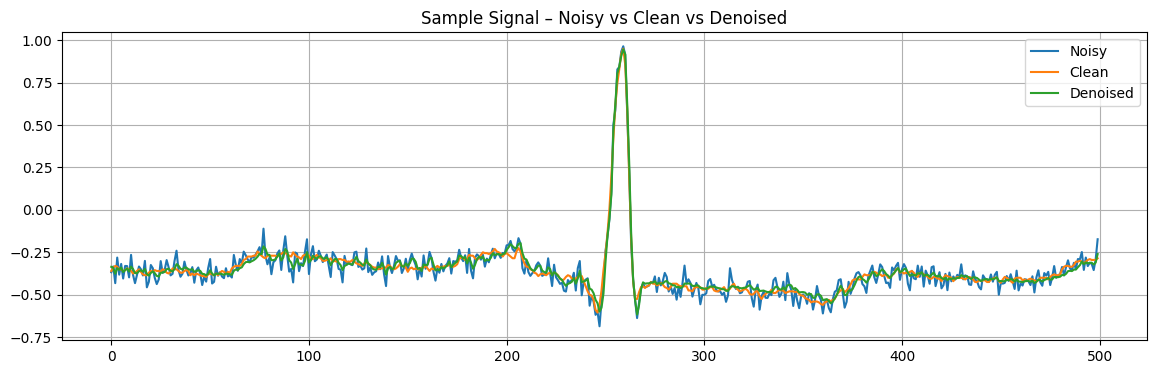

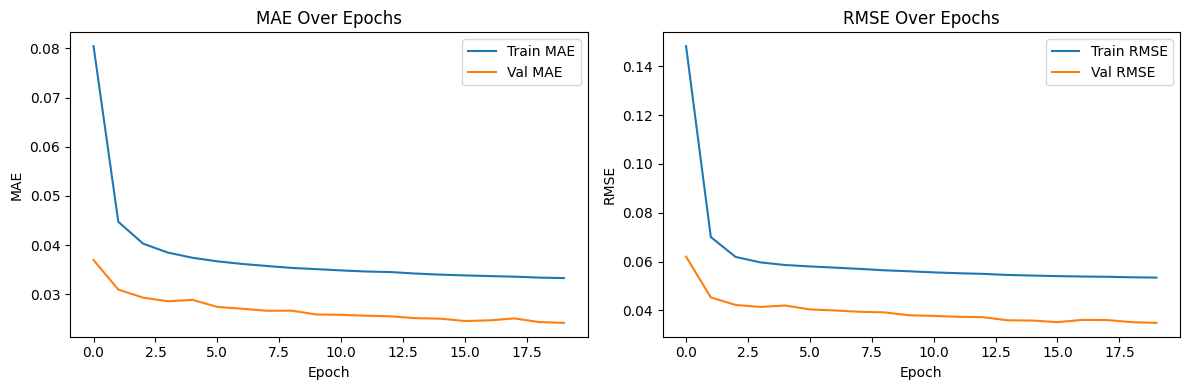

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Custom RMSE metric
def compute_rmse(y_actual, y_predicted):
    return K.sqrt(K.mean(K.square(y_predicted - y_actual)))

# Define the LSTM Denoising model
den_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEGMENT_LENGTH, 1), kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.2),
    LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.2),
    Dense(1)
])

den_model.compile(optimizer='adam', loss='mae', metrics=['mae', compute_rmse])

# Train the model
history = den_model.fit(
    X_tr, y_tr,
    validation_data=(X_te, y_te),
    epochs=20,
    batch_size=64,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

# Predict on test set
predictions = den_model.predict(X_te)

# Evaluation metrics
mae_val = mean_absolute_error(y_te.flatten(), predictions.flatten())
rmse_val = np.sqrt(mean_squared_error(y_te.flatten(), predictions.flatten()))

print("\n📊 Denoising Evaluation:")
print(f"MAE : {mae_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")

# Plot 1 sample: noisy vs clean vs denoised
plt.figure(figsize=(14, 4))
plt.plot(X_te[0].squeeze(), label='Noisy')
plt.plot(y_te[0].squeeze(), label='Clean')
plt.plot(predictions[0].squeeze(), label='Denoised')
plt.title("Sample Signal – Noisy vs Clean vs Denoised")
plt.legend()
plt.grid(True)
plt.show()

# Plot training MAE and RMSE
plt.figure(figsize=(12, 4))

# MAE
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("MAE Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

# RMSE (custom metric)
if 'compute_rmse' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['compute_rmse'], label='Train RMSE')
    plt.plot(history.history['val_compute_rmse'], label='Val RMSE')
    plt.title("RMSE Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.legend()

plt.tight_layout()
plt.show()


In [15]:

# R-peak tagging

def r_peak_extraction(ecg, dist=150, prom=0.5):
    locs, _ = find_peaks(ecg, distance=dist, prominence=prom)
    tags = np.zeros_like(ecg, dtype=int)
    tags[locs] = 1
    return tags

for fname in csv_files:
    full_path = os.path.join(BASE_PATH, fname)
    df = pd.read_csv(full_path)
    if 'MLII' in df.columns:
        ecg = df['MLII'].fillna(method='ffill').values
        df['R_peak'] = r_peak_extraction(ecg)
        df.to_csv(full_path, index=False)

# R-peak sequence labeling

def extract_labeled_data(files, seg_len):
    features, labels = [], []
    for fname in files:
        data = pd.read_csv(os.path.join(BASE_PATH, fname))
        if 'MLII' not in data.columns or 'R_peak' not in data.columns:
            continue
        signal = data['MLII'].fillna(method='ffill').values
        rpeaks = data['R_peak'].fillna(0).astype(int).values
        for i in range(0, len(signal) - seg_len, seg_len):
            xseg, yseg = signal[i:i+seg_len], rpeaks[i:i+seg_len]
            features.append(xseg)
            labels.append(1 if np.any(yseg) else 0)
    return np.array(features)[..., np.newaxis], np.array(labels)

X_seq, y_seq = extract_labeled_data(csv_files, SEGMENT_LENGTH)
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)


<ipython-input-15-0a3d70f71c8c>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ecg = df['MLII'].fillna(method='ffill').values
<ipython-input-15-0a3d70f71c8c>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ecg = df['MLII'].fillna(method='ffill').values
<ipython-input-15-0a3d70f71c8c>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ecg = df['MLII'].fillna(method='ffill').values
<ipython-input-15-0a3d70f71c8c>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ecg = df['MLII'].fillna(method='ffill').values
<ipython-input-15-0a3d70f71c8c>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version.

In [16]:

# GRU classifier

classifier = Sequential([
    GRU(64, input_shape=(SEGMENT_LENGTH, 1)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

clf_history = classifier.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=64,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

y_hat = (classifier.predict(X_test) > 0.5).astype(int)

print("\nR-Peak Classification:")
print(classification_report(y_test, y_hat))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - accuracy: 0.9744 - loss: 0.1325 - val_accuracy: 0.9934 - val_loss: 0.0400
Epoch 2/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9937 - loss: 0.0421 - val_accuracy: 0.9934 - val_loss: 0.0394
Epoch 3/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9932 - loss: 0.0440 - val_accuracy: 0.9934 - val_loss: 0.0398
Epoch 4/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.9934 - loss: 0.0410 - val_accuracy: 0.9934 - val_loss: 0.0366
Epoch 5/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9940 - loss: 0.0358 - val_accuracy: 0.9934 - val_loss: 0.0383
Epoch 6/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9943 - loss: 0.0239 - val_accuracy: 0.9958 - val_loss: 0.0164
Epoch 7/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.9944 - loss: 0.0164 - val_accuracy: 0.9966 - val_loss: 0.0130
Epoch 8/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9965 - loss: 0.0125 - 

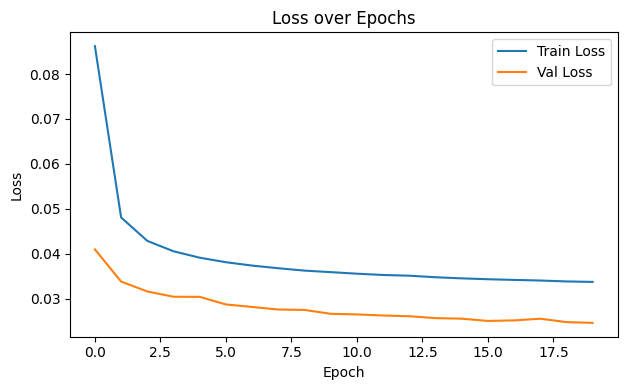


Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,933 (175.52 KB)

 Trainable params: 14,977 (58.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,956 (117.02 KB)

374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

Evaluation Metrics:
Accuracy   : 0.9972
Precision  : 0.9981
Recall     : 0.9991
F1 Score   : 0.9986


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# === 1. رسم نمودارهای دقت و ضرر ===
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy (فقط اگه در metrics مدل تعریف شده باشه)
if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

# === 2. تعداد پارامترهای مدل ===
print("\nModel Summary:")
classifier.summary()

# === 3. متغیر پیش‌بینی روی داده تست ===
y_pred = classifier.predict(X_test).flatten()
y_pred_label = (y_pred > 0.5).astype(int)

# محاسبه معیارهای ارزیابی
acc = accuracy_score(y_test, y_pred_label)
prec = precision_score(y_test, y_pred_label)
rec = recall_score(y_test, y_pred_label)
f1 = f1_score(y_test, y_pred_label)

# نمایش نتایج
print("\nEvaluation Metrics:")
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {prec:.4f}")
print(f"Recall     : {rec:.4f}")
print(f"F1 Score   : {f1:.4f}")



🌀 Predicting denoised signals from noisy input...
374/374 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
🔍 Predicting R-peak existence from denoised signal using GRU model...
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

📊 Evaluation after Denoising + GRU Classification:
Accuracy : 0.9975
Precision: 0.9982
Recall   : 0.9992
F1 Score : 0.9987

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.73      0.79        79
           1       1.00      1.00      1.00     11872

    accuracy                           1.00     11951
   macro avg       0.93      0.87      0.90     11951
weighted avg       1.00      1.00      1.00     11951



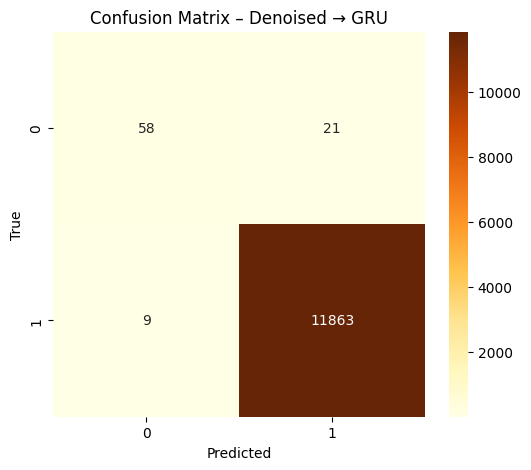

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. عبور سیگنال نویزی از مدل denoising
print("🌀 Predicting denoised signals from noisy input...")
denoised_test = den_model.predict(X_test)

# 2. عبور خروجی denoised از مدل GRU (classifier = مدل بند پ)
print("🔍 Predicting R-peak existence from denoised signal using GRU model...")
y_hat_denoised = (classifier.predict(denoised_test) > 0.5).astype(int)

# 3. محاسبه متریک‌ها (Accuracy, Precision, Recall, F1)
acc = accuracy_score(y_test, y_hat_denoised)
prec = precision_score(y_test, y_hat_denoised)
rec = recall_score(y_test, y_hat_denoised)
f1 = f1_score(y_test, y_hat_denoised)

print("\n📊 Evaluation after Denoising + GRU Classification:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_hat_denoised))

# 4. رسم confusion matrix
conf_matrix = confusion_matrix(y_test, y_hat_denoised)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrBr')
plt.title("Confusion Matrix – Denoised → GRU")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
